# SC4002 Assignment - Part 3.1, 3.3, & 3.4: Final Tuned Models

**Team 3: Aaron Chen & Javier Tin**

This notebook implements and evaluates the **best tuned version** of all models required for Parts 3.1, 3.3, and 3.4, based on the results from our `hyperforadv.ipynb`  AND `Hyperparameter_tuning.ipynb` grid search.

1.  **Part 3.1: Baselines (BiLSTM & BiGRU)**
    - Trains the BiLSTM and BiGRU models using their optimal hyperparameters from prior tuning.
2.  **Part 3.3: Architectural Improvement (Attention)**
    - Implements the `ImprovedBiLSTM_Attention` model using its *newly tuned* optimal hyperparameters.
3.  **Part 3.4: Weak Topic Improvement (Focal Loss)**
    - Implements the baseline `BiLSTM_Model` architecture with the `FocalLoss` criterion, using its *newly tuned* optimal hyperparameters.

All experiments use **SEED = 216** for reproducibility.

In [1]:
# === 1. Core PyTorch & System Imports ===
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import sys
import os
import random
import numpy as np
import re

# === 2. Set Random Seed for Reproducibility ===
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.use_deterministic_algorithms(True) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False 
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8' 

SEED = 216
set_seed(SEED)

# === 3. Plotting & Metrics ===
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# === 4. Check PyTorch and CUDA ===
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Current device: {torch.cuda.current_device()}")
    print(f"Device name: {torch.cuda.get_device_name(0)}")

# === 5. Data Pipeline Import ===
try:
    from data_pipeline import (
        train_iterator, 
        valid_iterator, 
        test_iterator, 
        TEXT, 
        LABEL, 
        create_embedding_layer,
        device,
        BATCH_SIZE
    )
    print("\n✓ Successfully imported data pipeline.")
    print(f"  - Using device: {device}")
    print(f"  - Batch Size: {BATCH_SIZE}")
except ImportError:
    print("--- ERROR ---")
    print("Could not find 'data_pipeline.py'.")
    print("Please make sure 'data_pipeline.py' is in the same directory as this notebook.")

PyTorch version: 2.5.1
CUDA available: True
CUDA version: 12.1
Current device: 0
Device name: NVIDIA GeForce RTX 4060 Laptop GPU


c:\Users\user\anaconda3\envs\nlp_project\Lib\site-packages\torchtext\vocab.py:432: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.itos, self.stoi, self.vectors, self.dim


✓ Successfully imported data pipeline.
  - Using device: cuda
  - Batch Size: 64


## Helper Functions (Train, Evaluate, Plot, Metrics)

**Improvement:** The `train_epoch` function now includes **gradient clipping (clip_grad=1.0)** by default. This prevents exploding gradients and helps stabilize training for all our RNN models.

In [2]:
def get_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train_epoch(model, iterator, optimizer, criterion, clip_grad=1.0):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        text, lengths = batch.text
        predictions = model(text, lengths)
        loss = criterion(predictions, batch.label)
        acc = get_accuracy(predictions, batch.label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate_epoch(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, lengths = batch.text
            predictions = model(text, lengths)
            loss = criterion(predictions, batch.label)
            acc = get_accuracy(predictions, batch.label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def get_topic_accuracy(model, iterator, criterion, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in iterator:
            text, lengths = batch.text
            predictions = model(text, lengths)
            top_pred = predictions.argmax(1)
            all_preds.extend(top_pred.to('cpu').numpy())
            all_labels.extend(batch.label.to('cpu').numpy())
    
    target_names = [LABEL.vocab.itos[i] for i in range(len(LABEL.vocab))]
    # Set zero_division=0 to handle cases where a class has 0 predictions (e.g., in a bad run)
    return classification_report(all_labels, all_preds, target_names=target_names, zero_division=0)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def plot_curves(train_losses, val_losses, train_accs, val_accs, title_prefix=''):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Validation Loss')
    ax1.set_title(f'{title_prefix} Loss Curves')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Validation Accuracy')
    ax2.set_title(f'{title_prefix} Accuracy Curves')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

def extract_f1_scores(classification_report_text):
    scores = {}
    lines = classification_report_text.strip().split('\n')
    for line in lines[2:-4]:
        parts = re.split(r'\s+', line.strip())
        if len(parts) >= 4:
            class_name = parts[0]
            f1_score = float(parts[3])
            scores[class_name] = f1_score
    return scores

## Model Definitions

We define all necessary model architectures and loss functions here.

In [3]:
# 1. Baseline BiLSTM Model (Part 3.1)
# This architecture uses only the final hidden state.
class BiLSTM_Model(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=False
        )
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        last_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped_hidden = self.dropout(last_hidden_state)
        prediction = self.fc(dropped_hidden)
        return prediction

# 2. Baseline BiGRU Model (Part 3.1)
# This architecture also uses only the final hidden state.
class BiGRU_Model(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=False
        )
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        packed_output, hidden = self.gru(packed_embedded)
        last_hidden_state = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        dropped_hidden = self.dropout(last_hidden_state)
        prediction = self.fc(dropped_hidden)
        return prediction

# 3. IMPROVED Attention Module (Part 3.3)
class ImprovedAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attention = nn.Linear(hidden_dim * 2, hidden_dim * 2)
        self.context_vector = nn.Linear(hidden_dim * 2, 1, bias=False)
        self.dropout = nn.Dropout(0.3) # Specific dropout for attention
        
    def forward(self, lstm_output, final_hidden):
        lstm_output = lstm_output.permute(1, 0, 2)  # (batch, seq_len, hidden*2)
        energy = torch.tanh(self.attention(lstm_output))
        attention_weights = F.softmax(self.context_vector(energy), dim=1)
        attention_weights = self.dropout(attention_weights)
        context = torch.bmm(attention_weights.transpose(1, 2), lstm_output)
        return context.squeeze(1)

# 4. IMPROVED BiLSTM + Attention (Part 3.3)
# This architecture uses all hidden states + attention + layer norm
class ImprovedBiLSTM_Attention(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super().__init__()
        self.embedding = create_embedding_layer(freeze=False)
        self.lstm = nn.LSTM(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=False
        )
        self.layer_norm = nn.LayerNorm(hidden_dim * 2)
        self.attention = ImprovedAttention(hidden_dim)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        # Use the specific dropout rate from tuning for the final layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, lengths.to('cpu'), enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=False)
        output = self.layer_norm(output)
        context_vector = self.attention(output, hidden)
        dropped_context = self.dropout(context_vector)
        prediction = self.fc(dropped_context)
        return prediction

# 5. IMPROVED Focal Loss (Part 3.4)
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, label_smoothing=0.1):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', label_smoothing=self.label_smoothing)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()

print("✓ All model and loss function classes defined.")

✓ All model and loss function classes defined.


## Experiment 1 (Part 3.1): Baseline Models



### 1.1 Baseline BiLSTM (Tuned)

* **Params:** Hidden=256, Layers=3, Dropout=0.6, WD=1e-5

In [4]:
# Hyperparameters
INPUT_DIM = len(TEXT.vocab)
OUTPUT_DIM = len(LABEL.vocab)
EMBEDDING_DIM = create_embedding_layer().embedding_dim
N_EPOCHS = 10
BIDIRECTIONAL = True

# Best params from original tuning
LSTM_HIDDEN_DIM = 256
LSTM_N_LAYERS = 3
LSTM_DROPOUT = 0.6
LSTM_WEIGHT_DECAY = 1e-5

print("--- Hyperparameters Loaded ---")
print(f"LSTM Hidden: {LSTM_HIDDEN_DIM}, Layers: {LSTM_N_LAYERS}, Dropout: {LSTM_DROPOUT}, WDecay: {LSTM_WEIGHT_DECAY}")

--- Hyperparameters Loaded ---
LSTM Hidden: 256, Layers: 3, Dropout: 0.6, WDecay: 1e-05


In [5]:
# === Instantiate Baseline BiLSTM ===
model_baseline = BiLSTM_Model(
    INPUT_DIM, EMBEDDING_DIM, LSTM_HIDDEN_DIM, OUTPUT_DIM,
    LSTM_N_LAYERS, BIDIRECTIONAL, LSTM_DROPOUT
).to(device)

optimizer_baseline = optim.Adam(model_baseline.parameters(), weight_decay=LSTM_WEIGHT_DECAY)
criterion_baseline = nn.CrossEntropyLoss().to(device)

print("✓ BiLSTM Baseline Model (Part 3.1) initialized.")

✓ BiLSTM Baseline Model (Part 3.1) initialized.


In [6]:
# === Training Loop (Baseline BiLSTM) ===
MODEL_SAVE_PATH_BASELINE = 'bilstm-baseline-model.pt'

best_valid_loss = float('inf')
history_baseline = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting Baseline BiLSTM Training (Part 3.1) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_baseline, train_iterator, optimizer_baseline, criterion_baseline)
    valid_loss, valid_acc = evaluate_epoch(model_baseline, valid_iterator, criterion_baseline)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    history_baseline['train_loss'].append(train_loss)
    history_baseline['val_loss'].append(valid_loss)
    history_baseline['train_acc'].append(train_acc)
    history_baseline['val_acc'].append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_baseline.state_dict(), MODEL_SAVE_PATH_BASELINE)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- Baseline BiLSTM Training Complete ---")

--- Starting Baseline BiLSTM Training (Part 3.1) ---
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.215 | Train Acc: 50.33%
	 Val. Loss: 0.668 |  Val. Acc: 77.34%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.568 | Train Acc: 80.24%
	 Val. Loss: 0.854 |  Val. Acc: 73.35%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.380 | Train Acc: 87.41%
	 Val. Loss: 0.559 |  Val. Acc: 82.38%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.227 | Train Acc: 93.46%
	 Val. Loss: 0.500 |  Val. Acc: 84.38%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.133 | Train Acc: 96.35%
	 Val. Loss: 0.610 |  Val. Acc: 83.85%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.083 | Train Acc: 97.85%
	 Val. Loss: 0.606 |  Val. Acc: 87.07%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.080 | Train Acc: 97.78%
	 Val. Loss: 0.602 |  Val. Acc: 87.33%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.058 | Train Acc: 98.71%
	 Val. Loss: 0.856 |  Val. Acc: 82.03%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.029 | Train Acc: 99.23%
	 Val. Loss: 0

Loss and Accuracy Curves for Baseline BiLSTM (Part 3.1)


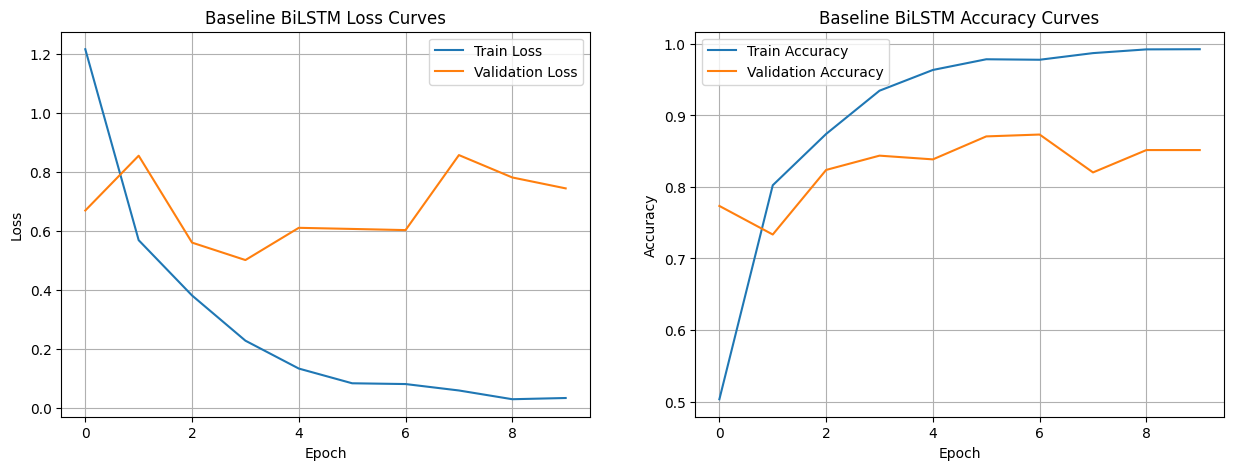


>>> Baseline BiLSTM Test Loss: 0.608 | Test Acc: 80.20%

--- Baseline BiLSTM Classification Report (for 3.4 comparison) ---
              precision    recall  f1-score   support

        ENTY       0.54      0.82      0.65        94
         HUM       0.84      0.94      0.88        65
        DESC       0.89      0.59      0.71       138
         NUM       0.98      0.90      0.94       113
         LOC       0.87      0.90      0.88        81
        ABBR       1.00      0.67      0.80         9

    accuracy                           0.80       500
   macro avg       0.85      0.80      0.81       500
weighted avg       0.84      0.80      0.80       500



C:\Users\user\AppData\Local\Temp\ipykernel_11984\83732155.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BASEL

In [7]:
# --- Plot & Evaluate (Baseline BiLSTM) ---
print("Loss and Accuracy Curves for Baseline BiLSTM (Part 3.1)")
plot_curves(
    history_baseline['train_loss'], history_baseline['val_loss'],
    history_baseline['train_acc'], history_baseline['val_acc'],
    'Baseline BiLSTM'
)

model_baseline.load_state_dict(torch.load(MODEL_SAVE_PATH_BASELINE))
test_loss_baseline, test_acc_baseline = evaluate_epoch(model_baseline, test_iterator, criterion_baseline)
print(f"\n>>> Baseline BiLSTM Test Loss: {test_loss_baseline:.3f} | Test Acc: {test_acc_baseline*100:.2f}%")

# Get report for Part 3.4 comparison
report_baseline = get_topic_accuracy(model_baseline, test_iterator, criterion_baseline, device)
print("\n--- Baseline BiLSTM Classification Report (for 3.4 comparison) ---")
print(report_baseline)

### 1.2 Baseline BiGRU (Tuned)

* **Params:** Hidden=512, Layers=2, Dropout=0.5, WD=1e-6

In [8]:
# Best params from original tuning
GRU_HIDDEN_DIM = 512
GRU_N_LAYERS = 2
GRU_DROPOUT = 0.5
GRU_WEIGHT_DECAY = 1e-6

print("--- Hyperparameters Loaded ---")
print(f"GRU Hidden: {GRU_HIDDEN_DIM}, Layers: {GRU_N_LAYERS}, Dropout: {GRU_DROPOUT}, WDecay: {GRU_WEIGHT_DECAY}")

# === Instantiate Baseline BiGRU ===
model_gru = BiGRU_Model(
    INPUT_DIM, EMBEDDING_DIM, GRU_HIDDEN_DIM, OUTPUT_DIM,
    GRU_N_LAYERS, BIDIRECTIONAL, GRU_DROPOUT
).to(device)

optimizer_gru = optim.Adam(model_gru.parameters(), weight_decay=GRU_WEIGHT_DECAY)
criterion_gru = nn.CrossEntropyLoss().to(device)

print("✓ BiGRU Baseline Model (Part 3.1) initialized.")

--- Hyperparameters Loaded ---
GRU Hidden: 512, Layers: 2, Dropout: 0.5, WDecay: 1e-06
✓ BiGRU Baseline Model (Part 3.1) initialized.


In [9]:
# === Training Loop (Baseline BiGRU) ===
MODEL_SAVE_PATH_GRU = 'bigru-baseline-model.pt'

best_valid_loss = float('inf')
history_gru = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting Baseline BiGRU Training (Part 3.1) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_gru, train_iterator, optimizer_gru, criterion_gru)
    valid_loss, valid_acc = evaluate_epoch(model_gru, valid_iterator, criterion_gru)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    history_gru['train_loss'].append(train_loss)
    history_gru['val_loss'].append(valid_loss)
    history_gru['train_acc'].append(train_acc)
    history_gru['val_acc'].append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_gru.state_dict(), MODEL_SAVE_PATH_GRU)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- Baseline BiGRU Training Complete ---")

--- Starting Baseline BiGRU Training (Part 3.1) ---
Epoch: 01 | Epoch Time: 0m 0s
	Train Loss: 0.908 | Train Acc: 63.39%
	 Val. Loss: 0.527 |  Val. Acc: 81.60%
Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.427 | Train Acc: 85.02%
	 Val. Loss: 0.414 |  Val. Acc: 85.16%
Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.224 | Train Acc: 91.89%
	 Val. Loss: 0.478 |  Val. Acc: 84.46%
Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.116 | Train Acc: 96.06%
	 Val. Loss: 0.457 |  Val. Acc: 87.24%
Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 0.041 | Train Acc: 98.78%
	 Val. Loss: 0.579 |  Val. Acc: 87.76%
Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.030 | Train Acc: 99.09%
	 Val. Loss: 0.522 |  Val. Acc: 87.85%
Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.013 | Train Acc: 99.59%
	 Val. Loss: 0.650 |  Val. Acc: 87.50%
Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.016 | Train Acc: 99.55%
	 Val. Loss: 0.593 |  Val. Acc: 88.19%
Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.014 | Train Acc: 99.62%
	 Val. Loss: 0.

Loss and Accuracy Curves for Baseline BiGRU (Part 3.1)


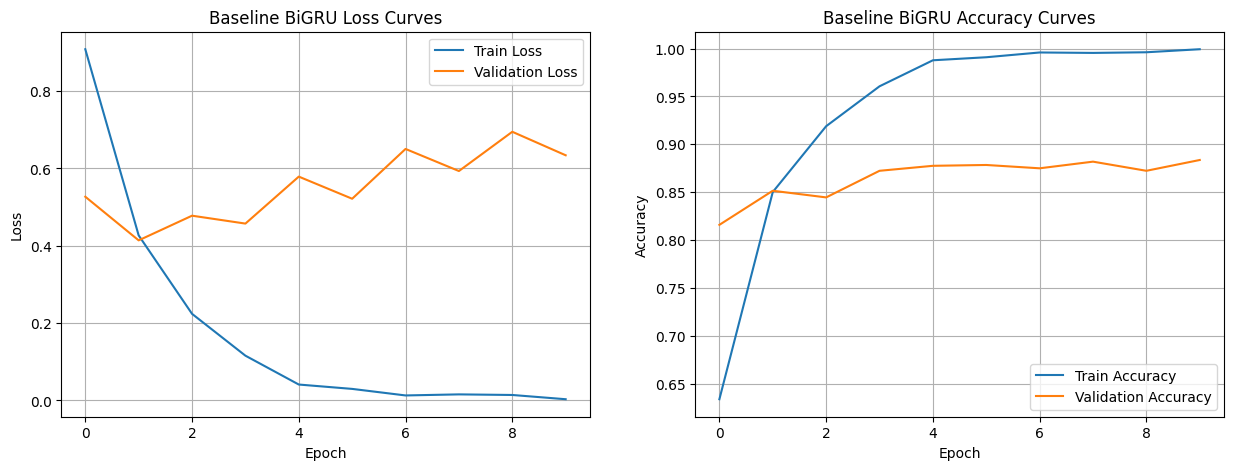


>>> Baseline BiGRU Test Loss: 0.306 | Test Acc: 89.00%


C:\Users\user\AppData\Local\Temp\ipykernel_11984\3253251076.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_gru.load_state_dict(torch.load(MODEL_SAVE_PATH_GRU))


In [10]:
# --- Plot & Evaluate (Baseline BiGRU) ---
print("Loss and Accuracy Curves for Baseline BiGRU (Part 3.1)")
plot_curves(
    history_gru['train_loss'], history_gru['val_loss'],
    history_gru['train_acc'], history_gru['val_acc'],
    'Baseline BiGRU'
)

model_gru.load_state_dict(torch.load(MODEL_SAVE_PATH_GRU))
test_loss_gru, test_acc_gru = evaluate_epoch(model_gru, test_iterator, criterion_gru)
print(f"\n>>> Baseline BiGRU Test Loss: {test_loss_gru:.3f} | Test Acc: {test_acc_gru*100:.2f}%")

## Experiment 2 (Part 3.3): Architectural Improvement (Attention)

Now we train the `ImprovedBiLSTM_Attention` model using its **own best hyperparameters** from the grid search.

* **Params:** Hidden=384, Layers=4, Dropout=0.5, WD=5e-6

In [11]:
# === Hyperparameters for Attention Model (from tuning) ===
ATTN_HIDDEN_DIM = 384
ATTN_N_LAYERS = 4
ATTN_DROPOUT = 0.5
ATTN_WEIGHT_DECAY = 5e-6

print("--- Hyperparameters Loaded ---")
print(f"Attention Hidden: {ATTN_HIDDEN_DIM}, Layers: {ATTN_N_LAYERS}, Dropout: {ATTN_DROPOUT}, WDecay: {ATTN_WEIGHT_DECAY}")

# === Instantiate Attention Model ===
model_attention = ImprovedBiLSTM_Attention(
    INPUT_DIM, EMBEDDING_DIM, ATTN_HIDDEN_DIM, OUTPUT_DIM,
    ATTN_N_LAYERS, BIDIRECTIONAL, ATTN_DROPOUT
).to(device)

optimizer_attention = optim.Adam(model_attention.parameters(), weight_decay=ATTN_WEIGHT_DECAY)
criterion_attention = nn.CrossEntropyLoss().to(device) # Standard loss

print("✓ IMPROVED BiLSTM + Attention Model (Part 3.3) initialized with tuned params.")

--- Hyperparameters Loaded ---
Attention Hidden: 384, Layers: 4, Dropout: 0.5, WDecay: 5e-06
✓ IMPROVED BiLSTM + Attention Model (Part 3.3) initialized with tuned params.


In [12]:
# === Training Loop (Attention) ===
MODEL_SAVE_PATH_ATTN = 'bilstm-attention-model.pt'

best_valid_loss = float('inf')
history_attention = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting IMPROVED Attention Training (Part 3.3) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_attention, train_iterator, optimizer_attention, criterion_attention)
    valid_loss, valid_acc = evaluate_epoch(model_attention, valid_iterator, criterion_attention)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    history_attention['train_loss'].append(train_loss)
    history_attention['val_loss'].append(valid_loss)
    history_attention['train_acc'].append(train_acc)
    history_attention['val_acc'].append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_attention.state_dict(), MODEL_SAVE_PATH_ATTN)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- IMPROVED Attention Training Complete ---")

--- Starting IMPROVED Attention Training (Part 3.3) ---
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 1.323 | Train Acc: 52.62%
	 Val. Loss: 0.702 |  Val. Acc: 74.83%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.696 | Train Acc: 76.83%
	 Val. Loss: 0.652 |  Val. Acc: 77.43%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.479 | Train Acc: 85.82%
	 Val. Loss: 0.550 |  Val. Acc: 83.59%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.341 | Train Acc: 90.73%
	 Val. Loss: 0.612 |  Val. Acc: 82.81%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.240 | Train Acc: 94.21%
	 Val. Loss: 0.557 |  Val. Acc: 86.37%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.176 | Train Acc: 95.86%
	 Val. Loss: 0.716 |  Val. Acc: 84.72%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.132 | Train Acc: 97.03%
	 Val. Loss: 0.665 |  Val. Acc: 84.90%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.082 | Train Acc: 98.32%
	 Val. Loss: 0.922 |  Val. Acc: 84.72%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.077 | Train Acc: 98.28%
	 Val. Loss

Loss and Accuracy Curves for IMPROVED BiLSTM + Attention (Part 3.3)


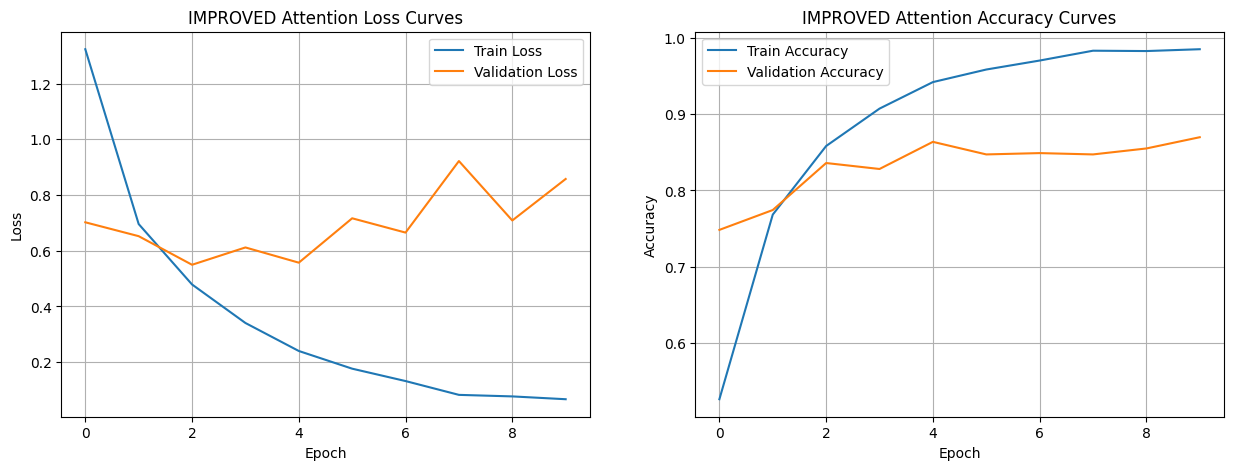


>>> IMPROVED Attention Test Loss: 0.497 | Test Acc: 83.77%

--- Attention Model Classification Report (for 3.4 comparison) ---
              precision    recall  f1-score   support

        ENTY       0.84      0.66      0.74        94
         HUM       0.93      0.86      0.90        65
        DESC       0.71      0.97      0.82       138
         NUM       0.96      0.88      0.92       113
         LOC       0.93      0.83      0.88        81
        ABBR       0.00      0.00      0.00         9

    accuracy                           0.84       500
   macro avg       0.73      0.70      0.71       500
weighted avg       0.84      0.84      0.83       500



C:\Users\user\AppData\Local\Temp\ipykernel_11984\3704177382.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_attention.load_state_dict(torch.load(MODEL_SAVE_PATH_AT

In [13]:
# --- Plot & Evaluate (Attention) ---
print("Loss and Accuracy Curves for IMPROVED BiLSTM + Attention (Part 3.3)")
plot_curves(
    history_attention['train_loss'], history_attention['val_loss'],
    history_attention['train_acc'], history_attention['val_acc'],
    'IMPROVED Attention'
)

model_attention.load_state_dict(torch.load(MODEL_SAVE_PATH_ATTN))
test_loss_attn, test_acc_attn = evaluate_epoch(model_attention, test_iterator, criterion_attention)
print(f"\n>>> IMPROVED Attention Test Loss: {test_loss_attn:.3f} | Test Acc: {test_acc_attn*100:.2f}%")

# Get report for Part 3.4 comparison
report_attention = get_topic_accuracy(model_attention, test_iterator, criterion_attention, device)
print("\n--- Attention Model Classification Report (for 3.4 comparison) ---")
print(report_attention)

## Experiment 3 (Part 3.4): Loss Function Improvement (Focal Loss)

Now we train the `BiLSTM_Model` (baseline architecture) with the `FocalLoss` criterion, using its **own best hyperparameters** from the grid search.

* **Params:** Hidden=384, Layers=3, Dropout=0.6, WD=1e-5

In [14]:
# === Hyperparameters for Focal Loss Model (from tuning) ===
FOCAL_HIDDEN_DIM = 384
FOCAL_N_LAYERS = 3
FOCAL_DROPOUT = 0.6
FOCAL_WEIGHT_DECAY = 1e-5

print("--- Hyperparameters Loaded ---")
print(f"Focal Loss Hidden: {FOCAL_HIDDEN_DIM}, Layers: {FOCAL_N_LAYERS}, Dropout: {FOCAL_DROPOUT}, WDecay: {FOCAL_WEIGHT_DECAY}")

# === Instantiate Focal Loss Model (on Baseline Architecture) ===
model_focal = BiLSTM_Model(
    INPUT_DIM, EMBEDDING_DIM, FOCAL_HIDDEN_DIM, OUTPUT_DIM,
    FOCAL_N_LAYERS, BIDIRECTIONAL, FOCAL_DROPOUT
).to(device)

optimizer_focal = optim.Adam(model_focal.parameters(), weight_decay=FOCAL_WEIGHT_DECAY)
criterion_focal = FocalLoss(alpha=1, gamma=2, label_smoothing=0.1).to(device)

print("✓ BiLSTM + Focal Loss Model (Part 3.4) initialized with tuned params.")

--- Hyperparameters Loaded ---
Focal Loss Hidden: 384, Layers: 3, Dropout: 0.6, WDecay: 1e-05
✓ BiLSTM + Focal Loss Model (Part 3.4) initialized with tuned params.


In [15]:
# === Training Loop (Focal Loss) ===
MODEL_SAVE_PATH_FOCAL = 'bilstm-focal-model.pt'

best_valid_loss = float('inf')
history_focal = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': []
}

print("--- Starting IMPROVED Focal Loss Training (Part 3.4) ---")

for epoch in range(N_EPOCHS):
    start_time = time.time()
    
    train_loss, train_acc = train_epoch(model_focal, train_iterator, optimizer_focal, criterion_focal)
    valid_loss, valid_acc = evaluate_epoch(model_focal, valid_iterator, criterion_focal)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    history_focal['train_loss'].append(train_loss)
    history_focal['val_loss'].append(valid_loss)
    history_focal['train_acc'].append(train_acc)
    history_focal['val_acc'].append(valid_acc)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model_focal.state_dict(), MODEL_SAVE_PATH_FOCAL)
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

print("--- IMPROVED Focal Loss Training Complete ---")

--- Starting IMPROVED Focal Loss Training (Part 3.4) ---
Epoch: 01 | Epoch Time: 0m 1s
	Train Loss: 0.770 | Train Acc: 53.32%
	 Val. Loss: 0.463 |  Val. Acc: 75.78%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.374 | Train Acc: 80.31%
	 Val. Loss: 0.362 |  Val. Acc: 81.68%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.224 | Train Acc: 89.83%
	 Val. Loss: 0.322 |  Val. Acc: 85.42%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.157 | Train Acc: 94.45%
	 Val. Loss: 0.282 |  Val. Acc: 87.24%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.123 | Train Acc: 96.31%
	 Val. Loss: 0.366 |  Val. Acc: 85.33%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.097 | Train Acc: 97.74%
	 Val. Loss: 0.410 |  Val. Acc: 82.99%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.086 | Train Acc: 98.17%
	 Val. Loss: 0.320 |  Val. Acc: 87.85%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.074 | Train Acc: 99.00%
	 Val. Loss: 0.326 |  Val. Acc: 88.02%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.064 | Train Acc: 99.43%
	 Val. Los

Loss and Accuracy Curves for IMPROVED Focal Loss (Part 3.4)


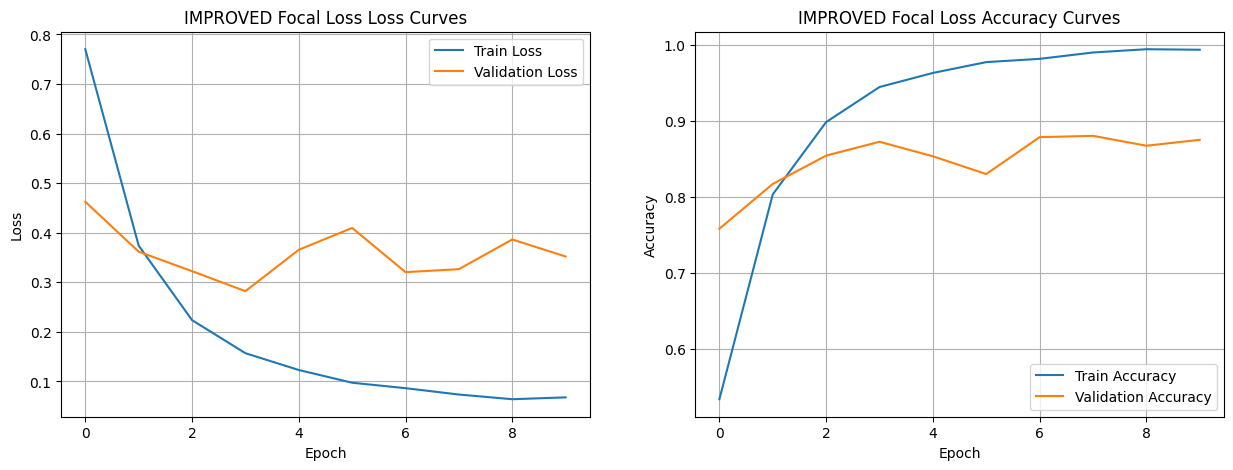


>>> IMPROVED Focal Loss Test Loss: 0.244 | Test Acc: 90.11%

--- Focal Loss Model Classification Report (Part 3.4) ---
              precision    recall  f1-score   support

        ENTY       0.86      0.82      0.84        94
         HUM       0.88      0.94      0.91        65
        DESC       0.89      0.96      0.92       138
         NUM       0.98      0.90      0.94       113
         LOC       0.88      0.94      0.91        81
        ABBR       1.00      0.33      0.50         9

    accuracy                           0.90       500
   macro avg       0.92      0.81      0.84       500
weighted avg       0.90      0.90      0.90       500



C:\Users\user\AppData\Local\Temp\ipykernel_11984\4284710367.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_focal.load_state_dict(torch.load(MODEL_SAVE_PATH_FOCAL)

In [16]:
# --- Plot & Evaluate (Focal Loss) ---
print("Loss and Accuracy Curves for IMPROVED Focal Loss (Part 3.4)")
plot_curves(
    history_focal['train_loss'], history_focal['val_loss'],
    history_focal['train_acc'], history_focal['val_acc'],
    'IMPROVED Focal Loss'
)

model_focal.load_state_dict(torch.load(MODEL_SAVE_PATH_FOCAL))
test_loss_focal, test_acc_focal = evaluate_epoch(model_focal, test_iterator, criterion_focal)
print(f"\n>>> IMPROVED Focal Loss Test Loss: {test_loss_focal:.3f} | Test Acc: {test_acc_focal*100:.2f}%")

# Get report for Part 3.4 comparison
report_focal = get_topic_accuracy(model_focal, test_iterator, criterion_focal, device)
print("\n--- Focal Loss Model Classification Report (Part 3.4) ---")
print(report_focal)

## Final Analysis (Q3.1, Q3.3, Q3.4)



In [17]:
# --- Final Summary Cell --- (From Final_Tuned_Analysis.py)
# This cell assumes the following variables have been populated by running the previous cells:
# - test_acc_baseline, test_acc_gru, test_acc_attn, test_acc_focal
# - report_baseline, report_attention, report_focal (string reports)
# - LABEL (from data_pipeline)

print("======================================================================================")
print("                       FINAL MODEL COMPARISON - OVERALL ACCURACY")
print("======================================================================================")
print(f"| {'Model':<35} | {'Assignment Part':<15} | {'Overall Acc (%)':<15} |")
print(f"| {'-'*35:<35} | {'-'*15:<15} | {'-'*15:<15} |")
print(f"| {'Baseline BiLSTM (Tuned)':<35} | {'Part 3.1 / 2(e)':<15} | {test_acc_baseline*100:<15.2f} |")
print(f"| {'Baseline BiGRU (Tuned)':<35} | {'Part 3.1':<15} | {test_acc_gru*100:<15.2f} |")
print(f"| {'BiLSTM + Attention (Tuned)':<35} | {'Part 3.3':<15} | {test_acc_attn*100:<15.2f} |")
print(f"| {'BiLSTM + Focal Loss (Tuned)':<35} | {'Part 3.4':<15} | {test_acc_focal*100:<15.2f} |")
print("======================================================================================")

print("\n\n==================================================================================================================")
print("                                 FINAL MODEL COMPARISON - F1-SCORES BY TOPIC (with Improvement Check)")
print("==================================================================================================================")

# Helper function to re-extract F1 scores, including macro and weighted averages
def extract_all_f1_scores(classification_report_text):
    scores = {}
    lines = classification_report_text.strip().split('\n')
    
    # Get class F1 scores
    for line in lines[2:-4]: 
        parts = re.split(r'\s+', line.strip()) # Use regex split for robust spacing
        if len(parts) >= 4:
            class_name = parts[0]
            f1_score = float(parts[3])
            scores[class_name] = f1_score
    
    # Get macro avg F1
    macro_line = [line for line in lines if 'macro avg' in line]
    if macro_line:
        parts = re.split(r'\s+', macro_line[0].strip())
        scores['macro avg'] = float(parts[3])

    # Get weighted avg F1
    weighted_line = [line for line in lines if 'weighted avg' in line]
    if weighted_line:
        parts = re.split(r'\s+', weighted_line[0].strip())
        scores['weighted avg'] = float(parts[3])
    return scores

# Re-extract full F1 score dictionaries
f1_baseline_full = extract_all_f1_scores(report_baseline)
f1_attention_full = extract_all_f1_scores(report_attention)
f1_focal_full = extract_all_f1_scores(report_focal)

# Get all keys in a specific order (excluding <unk> and <pad> if they exist)
all_keys = [LABEL.vocab.itos[i] for i in range(len(LABEL.vocab))]
all_keys.extend(['accuracy', 'macro avg', 'weighted avg'])

# Print header
print(f"| {'Metric':<15} | {'Baseline (3.1)':<18} | {'Attention (3.3)':<18} | {'Delta (vs 3.1)':<15} | {'Focal Loss (3.4)':<18} | {'Delta (vs 3.1)':<15} |")
print(f"| {'-'*15:<15} | {'-'*18:<18} | {'-'*18:<18} | {'-'*15:<15} | {'-'*18:<18} | {'-'*15:<15} |")

# Print F1 scores for each topic
for key in all_keys:
    if key in f1_baseline_full or key == 'accuracy': # Only print if the key exists
        if key == 'accuracy':
            base_val = test_acc_baseline
            attn_val = test_acc_attn
            focal_val = test_acc_focal
            
            # Format deltas
            delta_attn = attn_val - base_val
            delta_focal = focal_val - base_val
            
            print(f"| {'Overall Acc (%)':<15} | {base_val*100:<18.2f} | {attn_val*100:<18.2f} | {delta_attn*100:<+15.2f} | {focal_val*100:<18.2f} | {delta_focal*100:<+15.2f} |")
        else:
            base_f1 = f1_baseline_full.get(key, 0.0)
            attn_f1 = f1_attention_full.get(key, 0.0)
            focal_f1 = f1_focal_full.get(key, 0.0)
            
            # Format deltas
            delta_attn = attn_f1 - base_f1
            delta_focal = focal_f1 - base_f1
            
            print(f"| {key:<15} | {base_f1:<18.3f} | {attn_f1:<18.3f} | {delta_attn:<+15.3f} | {focal_f1:<18.3f} | {delta_focal:<+15.3f} |")
            
print("==================================================================================================================")


print("\n\n======================================================================================")
print("                       FULL CLASSIFICATION REPORTS (3.3 and 3.4 vs 3.1)")
print("======================================================================================")
print("\n--- REPORT 1: Baseline BiLSTM (Part 3.1) ---\n")
print(report_baseline)
print("\n--- REPORT 2: BiLSTM + Attention (Tuned) (Part 3.3) ---\n")
print(report_attention)
print("\n--- REPORT 3: BiLSTM (Baseline Arch) + Focal Loss (Tuned) (Part 3.4) ---\n")
print(report_focal)
print("======================================================================================")


                       FINAL MODEL COMPARISON - OVERALL ACCURACY
| Model                               | Assignment Part | Overall Acc (%) |
| ----------------------------------- | --------------- | --------------- |
| Baseline BiLSTM (Tuned)             | Part 3.1 / 2(e) | 80.20           |
| Baseline BiGRU (Tuned)              | Part 3.1        | 89.00           |
| BiLSTM + Attention (Tuned)          | Part 3.3        | 83.77           |
| BiLSTM + Focal Loss (Tuned)         | Part 3.4        | 90.11           |


                                 FINAL MODEL COMPARISON - F1-SCORES BY TOPIC (with Improvement Check)
| Metric          | Baseline (3.1)     | Attention (3.3)    | Delta (vs 3.1)  | Focal Loss (3.4)   | Delta (vs 3.1)  |
| --------------- | ------------------ | ------------------ | --------------- | ------------------ | --------------- |
| ENTY            | 0.650              | 0.740              | +0.090          | 0.840              | +0.190          |
| HUM             